# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [2]:
from google.colab import files
import pandas as pd
import numpy as np

# Load all data from Google Drive
training2_path = '/content/drive/My Drive/Machine Learning/data/training2.csv'
training1_path = '/content/drive/My Drive/Machine Learning/data/training1.csv'
test_path = '/content/drive/My Drive/Machine Learning/data/test.csv'
sample_valid_predictions_path = '/content/drive/My Drive/Machine Learning/data/sample_valid_predictions.csv'

# Load data into DataFrame
training2_data = pd.read_csv(training2_path)
training1_data = pd.read_csv(training1_path)
test_data = pd.read_csv(test_path)
sample_valid_predictions_data = pd.read_csv(sample_valid_predictions_path)

# Import Libraries

In [3]:
# Import all necessary libraries

from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# 1. Preprocessing
1.1 Handle NaN Values for training2 and test datasets

In [4]:
# Replace NaNs in the Training2 and test data with the mean among the columns for the same feature
imputer = SimpleImputer(strategy='mean')
training2_data[:] = imputer.fit_transform(training2_data[:])
test_data[:] = imputer.fit_transform(test_data[:])

# Put DF values into array
training2 = training2_data.values
training1 = training1_data.values
test = test_data.values
sample_valid_predictions = sample_valid_predictions_data.values

print(f"training2 shape: {training2.shape}")
print(f"training1 shape: {training1.shape}")
print(f"test shape: {test.shape}")

training2 shape: (2750, 3458)
training1 shape: (400, 3458)
test shape: (1000, 3456)


1.2 Divide Data and Concatenate Data

In [5]:
# Divide all training data into separate parts for convenience in testing and training

training2_cnn_feats = training2[:, 0:3072]     # Extract all CNN features from training2
training2_gist_feats = training2[:,3072:3456]  # Extract all GIST features from training2
training2_classes = training2[:,3456:3457]     # Extract all classes from training2
training2_conf = training2[:,3457:3458]        # Extract all confidences from training2
training2_all_feats = training2[:, 0:3456]     # Extract all CNN and GIST features from training2

training1_cnn_feats = training1[:, 0:3072]     # Extract all CNN features from training1
training1_gist_feats = training1[:,3072:3456]  # Extract all GIST features from training1
training1_classes = training1[:,3456:3457]     # Extract all classes from training1
training1_conf = training1[:,3457:3458]        # Extract all confidences from training1
training1_all_feats = training1[:, 0:3456]     # Extract all CNN and GIST features from training1

# Concatenate training1 and training2 features, classes, and confidences

training_all_gist_feats = np.concatenate((training1_gist_feats, training2_gist_feats)) # Concatenate only GIST features
training_all_cnn_feats = np.concatenate((training1_cnn_feats, training2_cnn_feats))    # Concatenate only CNN features
training_all_feats = np.concatenate((training1_all_feats, training2_all_feats))        # Concatenate all features
training_classes = np.concatenate((training1_classes, training2_classes))              # Concatenate classes
training_confidences = np.concatenate((training1_conf, training2_conf))                # Concatenate confidences

print("CNN shape:",training_all_cnn_feats.shape)
print("gist shape:",training_all_gist_feats.shape)
print("Class shape:",training_classes.shape)
print("Confidence shape:",training_confidences.shape)

CNN shape: (3150, 3072)
gist shape: (3150, 384)
Class shape: (3150, 1)
Confidence shape: (3150, 1)


1.3 Filter out training data. Keep only rows with confidence 1.0

In [6]:
# Set a threshold of 0.99 to keep only values that are equal to 1.0

confidence_threshold = 0.99
high_confidence_mask = training_confidences >= confidence_threshold  # create a mask of boolean values
high_confidence_mask = high_confidence_mask.squeeze()                # squeeze in 1st dimension

# Filter X (training1 and training2 concatenated only on CNN features) and y data
X_filtered = training_all_cnn_feats[high_confidence_mask]
y_filtered = training_classes[high_confidence_mask]
print(f"Current number of data rows: {X_filtered.shape[0]}")

Current number of data rows: 825


1.4 Split filtered data on train and test data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)

1.5 Apply Standardisation on training and test data

In [8]:
scaler = StandardScaler()

# Fit scaler on training data
scaler.fit(X_train)

# Standardise training and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

1.6 Perform Dimensionality Reduction on X_train and X_test

In [9]:
pca = PCA(n_components=0.7, random_state=42)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(f"Original number of features: {X_filtered.shape[1]}")
print(f"Reduced number of features: {X_train.shape[1]}")

Original number of features: 3072
Reduced number of features: 125


# 2. Training and testing models

2.1 Training with XGBoost Classifier

In [10]:
# Initialize the model
xgboost = xgb.XGBClassifier(max_depth=5, n_estimators=200, learning_rate=0.1, eval_metric='logloss')

# Train XGBoost Classifier
xgboost.fit(X_train, y_train)

# Test performance
predictions = xgboost.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7298387096774194


2.2 Training with Perceptron

Accuracy: 0.6935483870967742
Number of iterations: 17


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


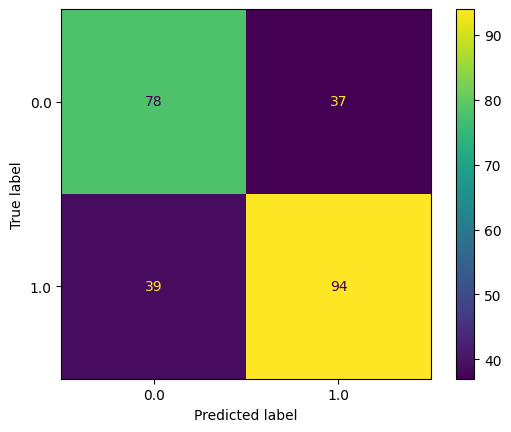

In [11]:
# Initialize the model
perceptron = Perceptron()

# Train Perceptron
perceptron.fit(X_train, y_train)

# Test Performance
predictions = perceptron.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

# Visualise Confusion Matrix
cm = confusion_matrix(y_test, predictions, labels=perceptron.classes_)
print(f"Accuracy: {accuracy}")
print(f"Number of iterations: {perceptron.n_iter_}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=perceptron.classes_)
disp.plot()

2.3 Training with Multilayer Perceptron

Accuracy: 0.6935483870967742
Number of iterations: 20


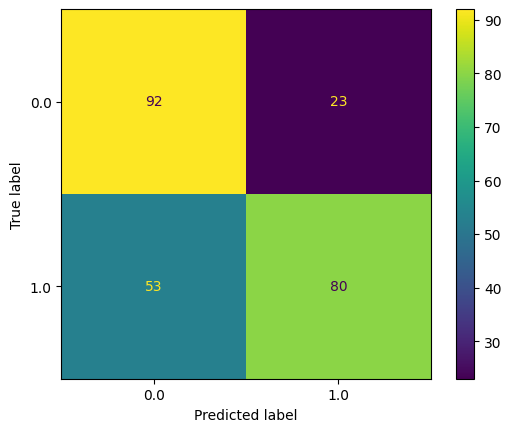

In [17]:
# Initialize the model
clf = MLPClassifier(activation="relu", solver="sgd", alpha=0.01, learning_rate_init=0.01, momentum=0.6, early_stopping=True,  validation_fraction=0.1)

# Traing Multilayer Perceptron
clf.fit(X_train, y_train.ravel())

# Test Performance
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

# Visualise Confusion Matrix
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
print(f"Accuracy: {accuracy}")
print(f"Number of iterations: {clf.n_iter_}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

2.4 Training with Support Vector Classifier

Accuracy: 0.7580645161290323
Number of iterations: [1035]


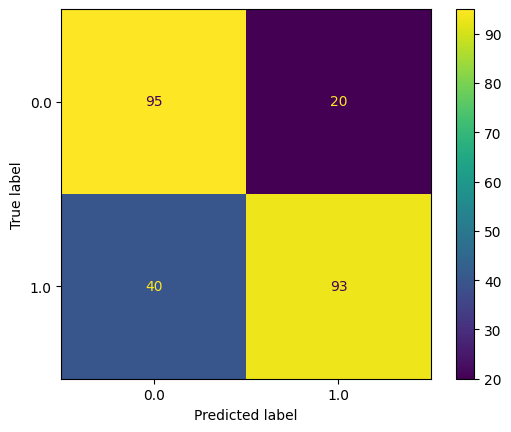

In [18]:
# Initialize the model
svc = SVC(kernel='rbf', C=2.1)

# Train SVC
svc.fit(X_train, y_train.ravel())

# Test performance
y_pred = svc.predict(X_test)
accuracy = accuracy_score(y_test.ravel(), y_pred)

# Visualise Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=svc.classes_)
print(f"Accuracy: {accuracy}")
print(f"Number of iterations: {svc.n_iter_}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()

2.5 Training with Random Forest Classifier

Accuracy: 0.6895161290322581


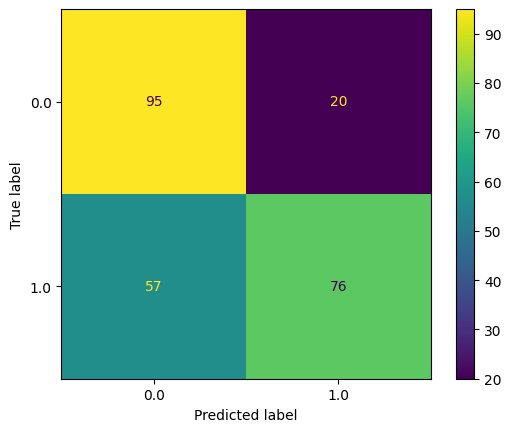

In [19]:
# Initialize the model
rf = RandomForestClassifier(n_estimators=400, criterion="log_loss", max_depth=10)

# Train RFC
rf.fit(X_train, y_train.ravel())

# test performance
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test.ravel(), y_pred)

# Visualise Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
print(f"Accuracy: {accuracy}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()

2.6 Training with Logistic Regression

Accuracy: 0.7419354838709677
Number of iterations: [6]


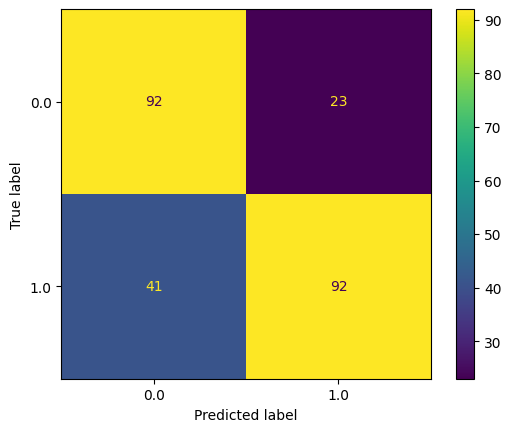

In [20]:
# Initialise the model
lr = LogisticRegression(solver="liblinear", penalty="l2", C=0.04, max_iter=300)

# Train LR
lr.fit(X_train, y_train.ravel())

# Test performance
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test.ravel(), y_pred)

# Visualise Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)
print(f"Accuracy: {accuracy}")
print(f"Number of iterations: {lr.n_iter_}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

2.7 Training with Decision Tree Classifier

Accuracy: 0.6330645161290323


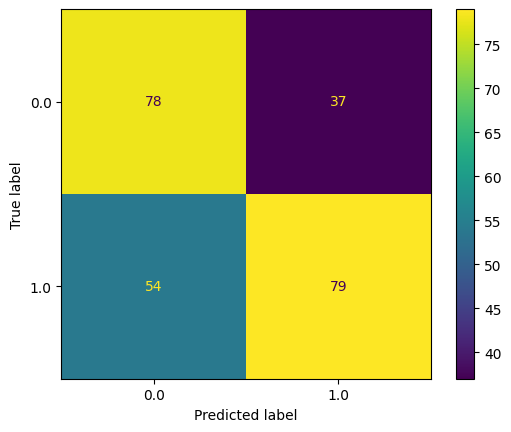

In [21]:
# Initialise the model
dtc = DecisionTreeClassifier(max_depth=None, max_features="log2")

# Train DTC
dtc.fit(X_train, y_train.ravel())

# Test Performance
y_pred = dtc.predict(X_test)
accuracy = accuracy_score(y_test.ravel(), y_pred)

# Visualise Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=dtc.classes_)
print(f"Accuracy: {accuracy}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
disp.plot()

2.8 Training a Combination of Classifiers

Accuracy: 0.7338709677419355


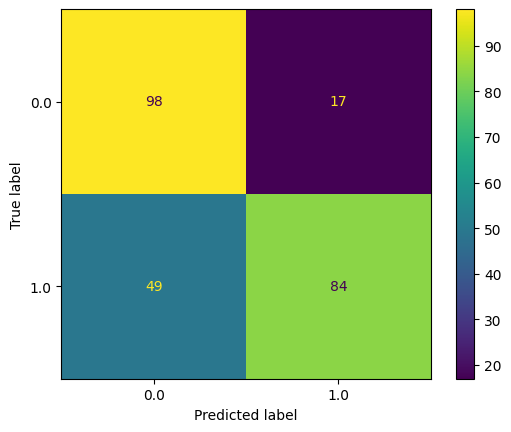

In [22]:
# Initialise Most Performed Classifiers
svc = SVC(kernel='rbf', C=2.1)
lr = LogisticRegression(solver="liblinear", penalty="l2", C=0.04, max_iter=300)

# Create a voting classifier
eclf = VotingClassifier(
    estimators=[('svm', svc), ('lr', lr)],
    voting='hard')

# Train the classifier
eclf.fit(X_train, y_train.ravel())

# Testing Performance
y_pred = eclf.predict(X_test)
accuracy = accuracy_score(y_test.ravel(), y_pred)

# Visualise Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=eclf.classes_)
print(f"Accuracy: {accuracy}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=eclf.classes_)
disp.plot()

# Predicting Testing Dataset

In [ ]:
# Initialize the model
svc = SVC(kernel='rbf', C=2.1)

# Train SVC
svc.fit(X_train, y_train.ravel())

# Extract only CNN features
testing = test[:, 0:3072]

# Apply Standardisation
testing = scaler.transform(testing)

# Apply Dimensionality Reduction
testing = pca.transform(testing)

# Predict with Support Vector Classifier
predictions = svc.predict(testing)

# Generate a CSV file

In [ ]:
df = pd.DataFrame(predictions, columns=['prediction'])
df.to_csv('predictions.csv', index=False)